## Свёрточные нейронные сети и аугментация данных
В этом задании необходимо обучить конволюционную нейросеть типа сети LeNet5, предложенную Яном Лекуном в 1998 году, для распознавания рукописных цифр из базы данных MNIST.  
Код ниже предлагает базовый вариант обучения, который даёт около 98-99% точности на тестовой выборке.  
Необходимо чуть-чуть улучшить данный код, введя **аугментацию** данных, т.е. расширить обучающий датасет за счёт дополнительных искажений исходных картинок:  
 - небольших случайных поворотов (rotate), 
 - дрожания (jitter), 
 - кроппинга (crop) 
 - и др.   
Для трансформации картинок используйте методы библиотеки `torchvision.transforms`, про которые можно прочитать [здесь](https://pytorch.org/vision/stable/transforms.html)  
Целью задания является - получить точность на тестовой выборке 99.5%.

In [149]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import  v2
from matplotlib import pyplot  as plt
import numpy as np
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper-parameters 
input_size = 28*28
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

cpu


# 1 Этап - подготовка данных!

In [150]:
# MNIST dataset 
transform = v2.Compose([
    transforms.ToTensor(),
    # v2.Resize(size=(29,29)),
    # v2.RandomResizedCrop(size=(28,28),scale=(0.999, 1.0),ratio=(1, 1)),
    # v2.RandomHorizontalFlip(p=0.1),
     v2.RandomAffine(degrees=2),
    v2.Normalize(mean=[0.485],std=[0.229]),
    v2.RandomRotation(degrees=12),
    # v2.ColorJitter(brightness=(0.875, 1.125)),
])
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform= v2.Compose([
                                              transforms.ToTensor(),
                                              v2.Normalize(mean=[0.485],std=[0.229]),
                                          ]))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# 2 Этап - Нейронная сеть!

<img src='Lenet5.png'>

In [151]:
# Fully connected neural network with one hidden layer
class Lenet5(nn.Module):
    def __init__(self, hidden_size1=500, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(20)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(50 * 4 * 4, hidden_size1) # fully connected
        self.fc2 = nn.Linear(hidden_size1, num_classes)  
    
    def forward(self, x): # вход размера 1 x 28 x 28
        out = self.conv1(x) # на выходе размер 20 x 24 x 24
        out = self.batchnorm1(out)
        out = self.maxpool(out) # на выходе размер 20 x 12 x 12
        out = self.relu(out)
        out = self.conv2(out)  # на выходе размер 50 x 8 x 8
        out = self.batchnorm2(out)
        out = self.maxpool(out) # на выходе размер 50 x 4 x 4
        out = self.relu(out)
        out = out.reshape(-1, 50 * 4 * 4) # на выходе размер 800
        out = self.fc1(out) # на выходе размер 500
        out = self.relu(out)
        out = self.fc2(out) # на выходе размер 10
        
        return out

model = Lenet5(hidden_size1=500, num_classes=10).to(device)

# 3 этап - Loss-функция и оптимизатор

In [152]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [153]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        #images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            #images = images.reshape(-1, 28*28).to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

    # Save the model checkpoint
    torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.0756
Epoch [1/5], Step [200/600], Loss: 0.1299
Epoch [1/5], Step [300/600], Loss: 0.1740
Epoch [1/5], Step [400/600], Loss: 0.0684
Epoch [1/5], Step [500/600], Loss: 0.0414
Epoch [1/5], Step [600/600], Loss: 0.0409
Accuracy of the network on the 10000 test images: 98.87 %
Epoch [2/5], Step [100/600], Loss: 0.0192
Epoch [2/5], Step [200/600], Loss: 0.1090
Epoch [2/5], Step [300/600], Loss: 0.0497
Epoch [2/5], Step [400/600], Loss: 0.1115
Epoch [2/5], Step [500/600], Loss: 0.1068
Epoch [2/5], Step [600/600], Loss: 0.0170
Accuracy of the network on the 10000 test images: 99.15 %
Epoch [3/5], Step [100/600], Loss: 0.0248
Epoch [3/5], Step [200/600], Loss: 0.0926
Epoch [3/5], Step [300/600], Loss: 0.0579
Epoch [3/5], Step [400/600], Loss: 0.1128
Epoch [3/5], Step [500/600], Loss: 0.0468
Epoch [3/5], Step [600/600], Loss: 0.0361
Accuracy of the network on the 10000 test images: 99.11 %
Epoch [4/5], Step [100/600], Loss: 0.0026
Epoch [4/5], Step [200/600],

# заключение

RandomRotation  оказывает большее влияние на точность модели, за ним следует Normalize, а затем RandomAffine .

In [154]:
# !pip install gradio
import gradio as gr

In [155]:
def mnist (input_img):
    trans = v2.Compose([
        transforms.ToTensor(),
        v2.Grayscale(num_output_channels=1)
    ])
    out_img = trans(input_img)
    out_img = torch.unsqueeze(out_img,1)
    pred = model(out_img)
    _,predicted = torch.max(pred, 1)
    print(predicted[0])
    out_img = torch.squeeze(out_img)
    t2 =  v2.Compose(
    [
        transforms.ToPILImage(),
        v2.Resize(size=(234,234))
    ])
    out_img = t2(out_img)
    return  out_img, predicted,"НПМмд-01-23"
    

demo = gr.Interface(mnist,inputs="sketchpad", outputs=["image","number","text"])
demo.launch()

Running on local URL:  http://127.0.0.1:7923

To create a public link, set `share=True` in `launch()`.


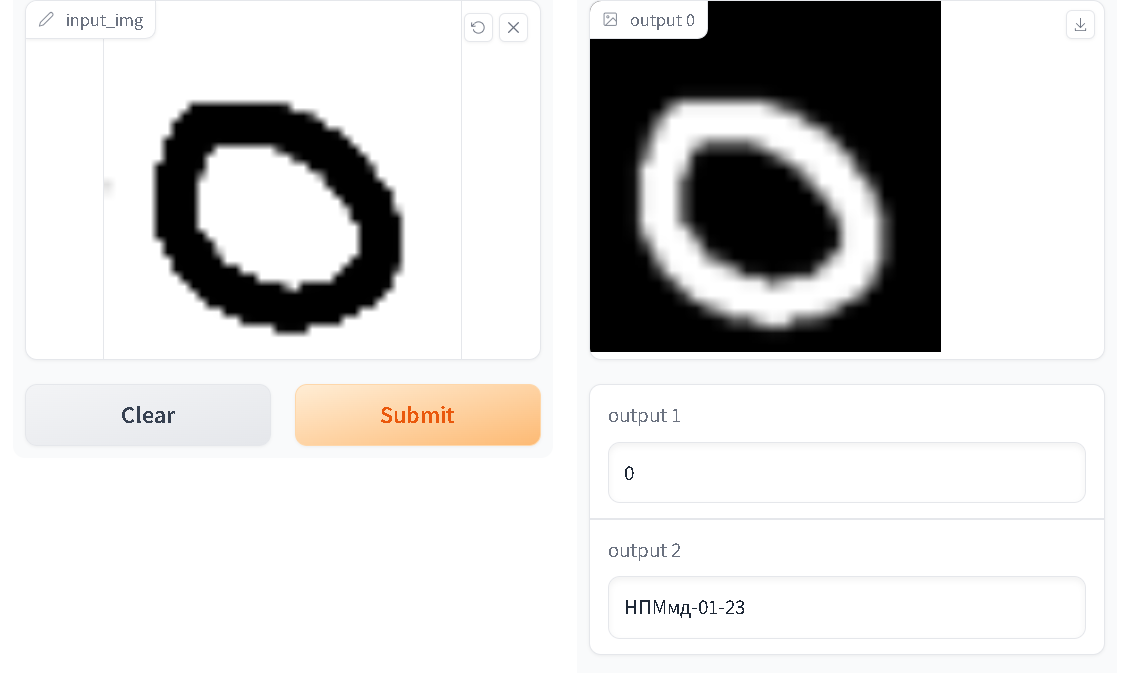

In [156]:
Image.open("0.png")

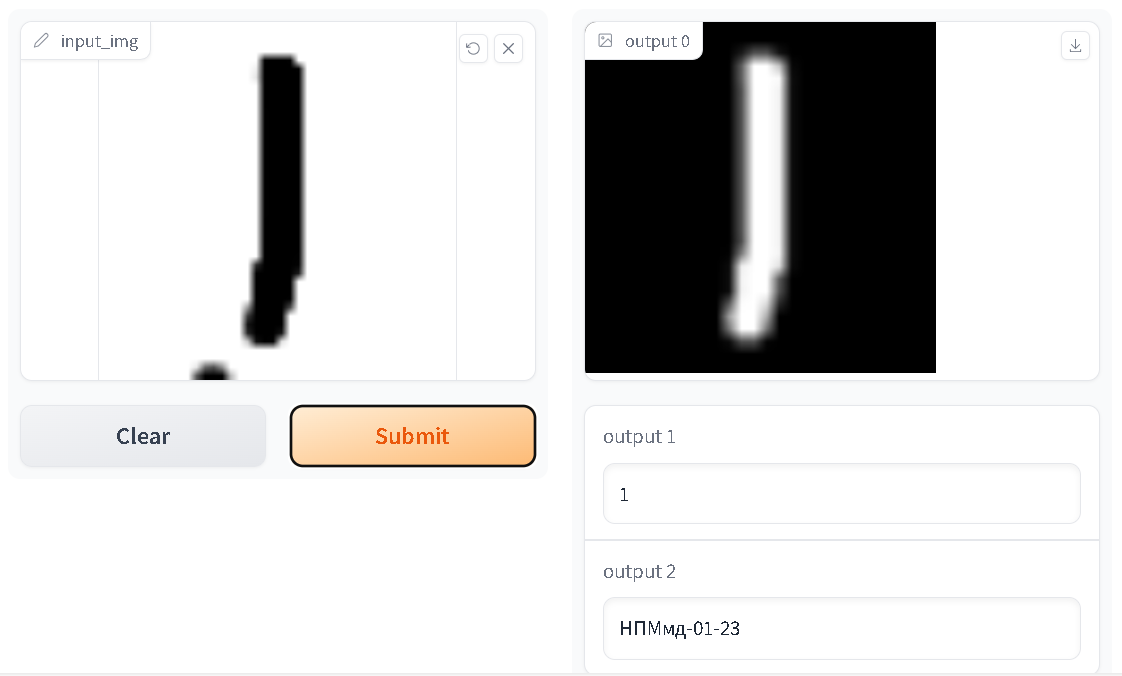

In [157]:
Image.open("1.png")

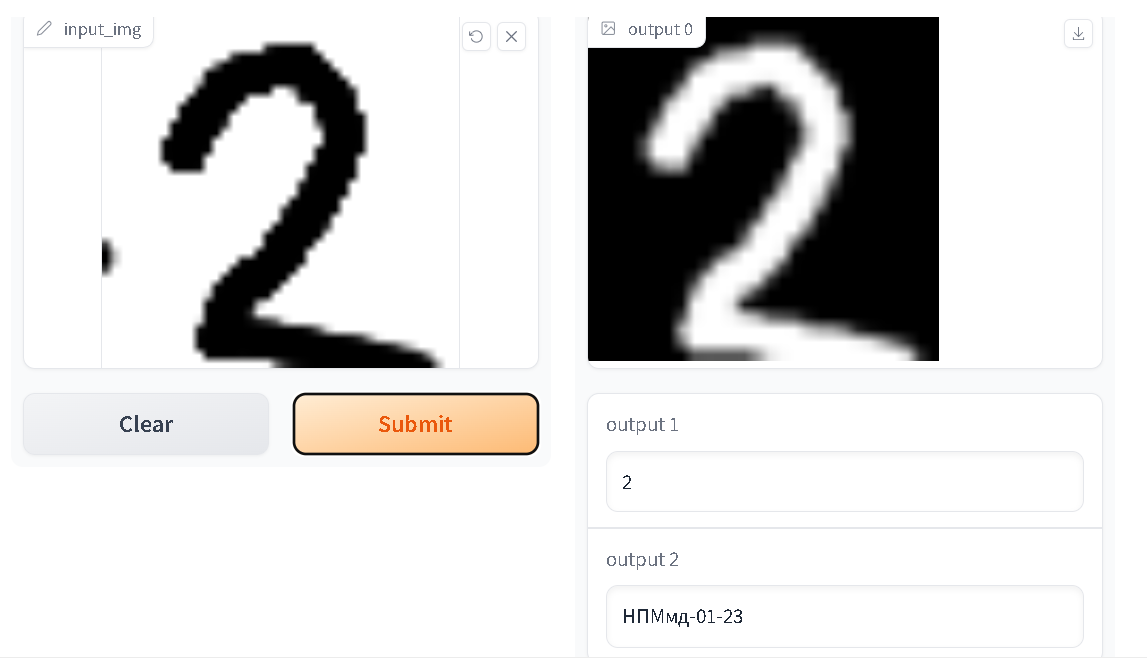

In [158]:
Image.open("2.png")

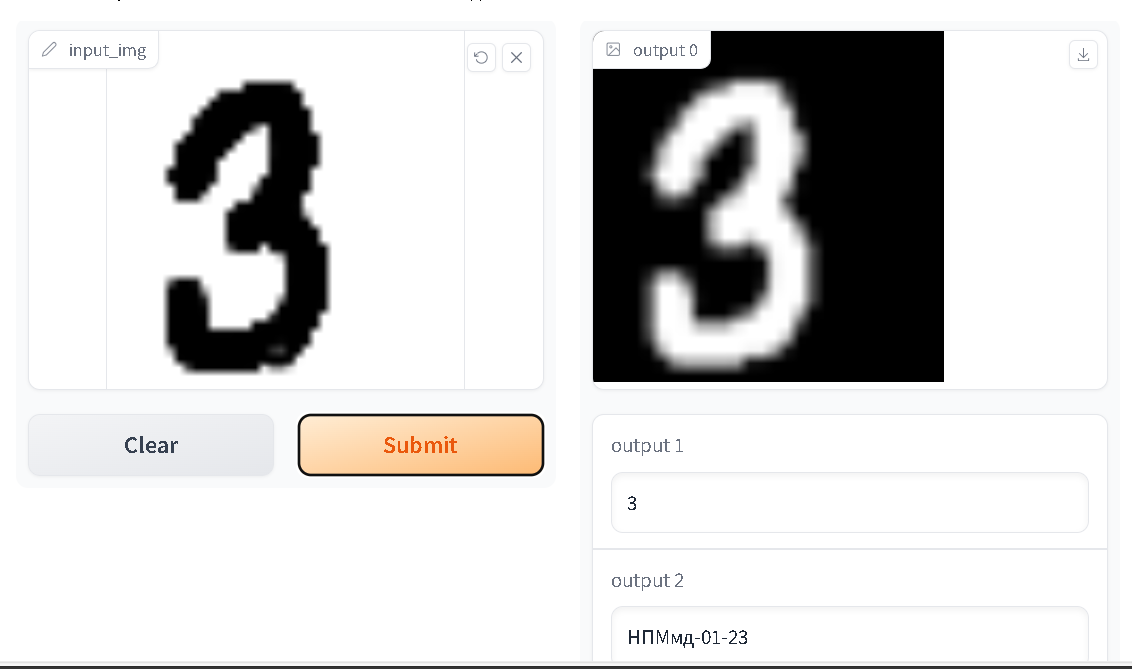

In [159]:
Image.open("3.png")

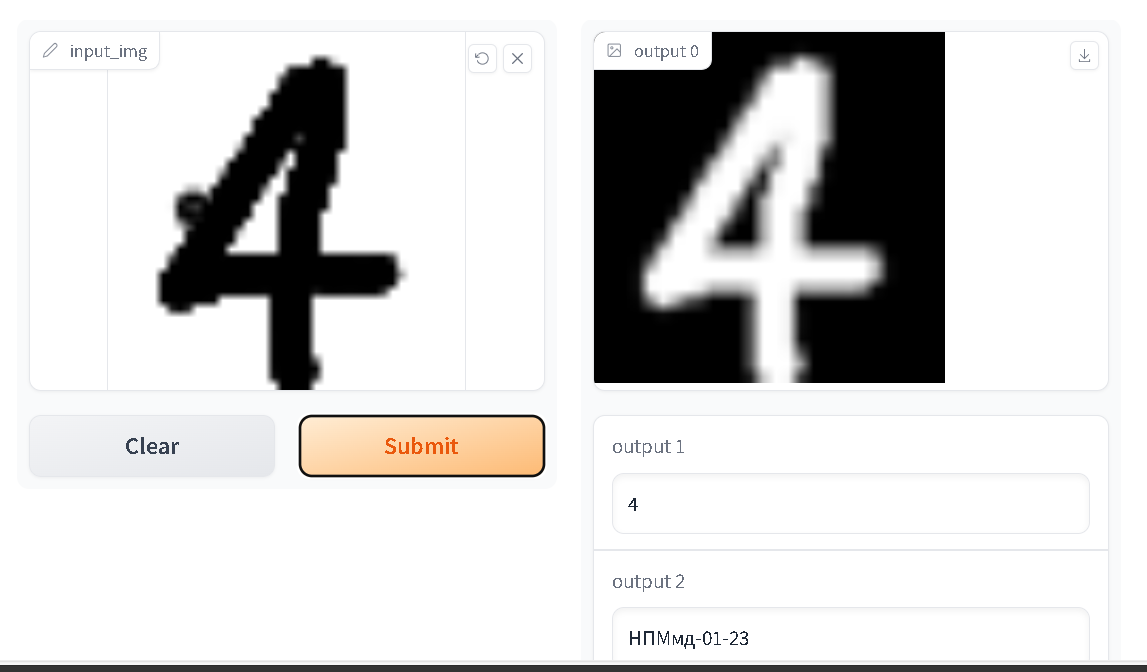

In [160]:
Image.open("4.png")

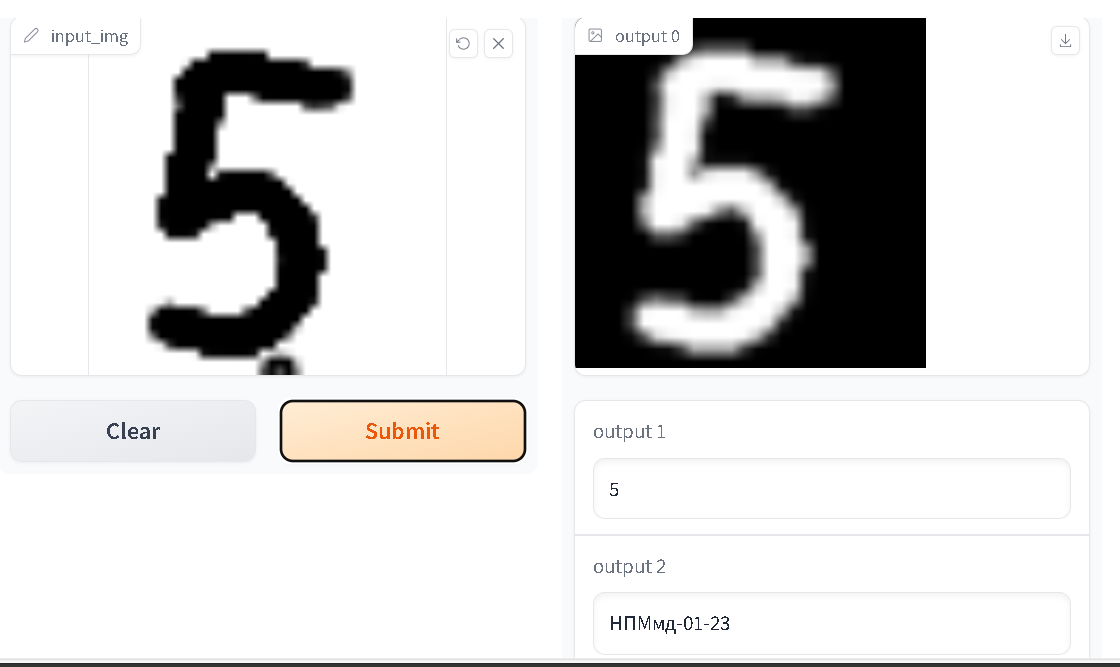

In [161]:
Image.open("5.png")

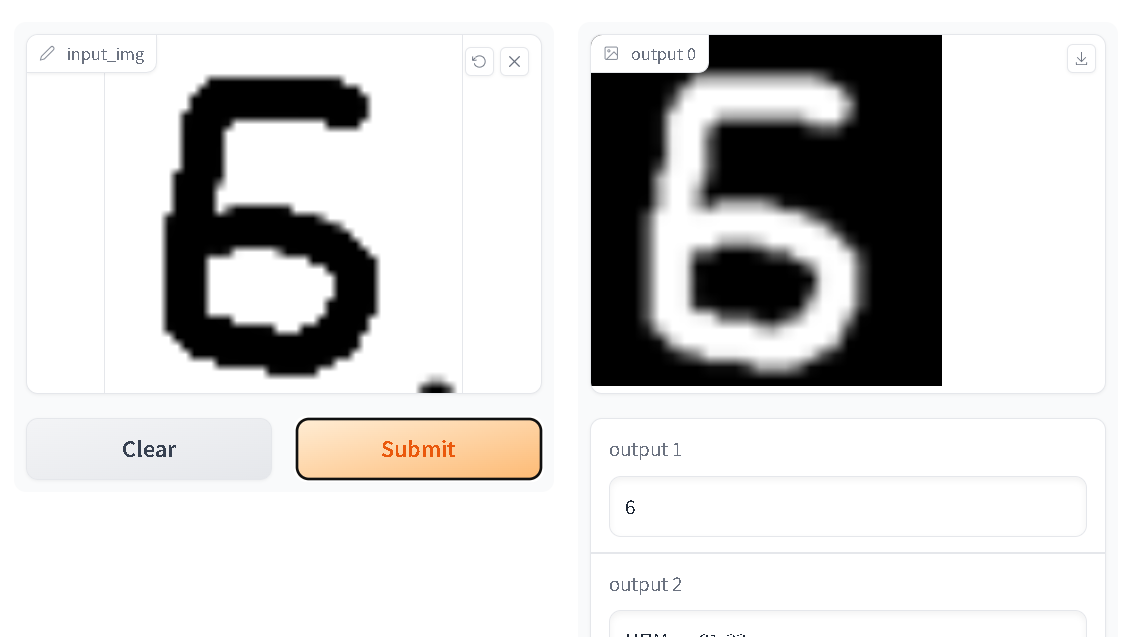

In [162]:
Image.open("6.png")

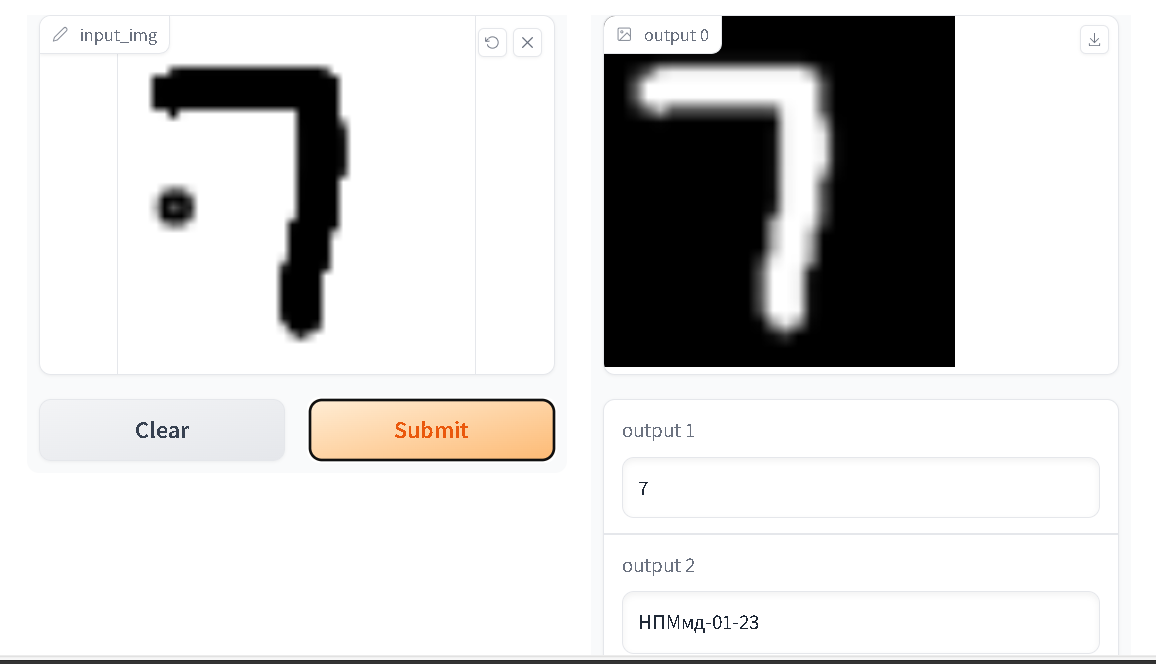

In [163]:
Image.open("7.png")

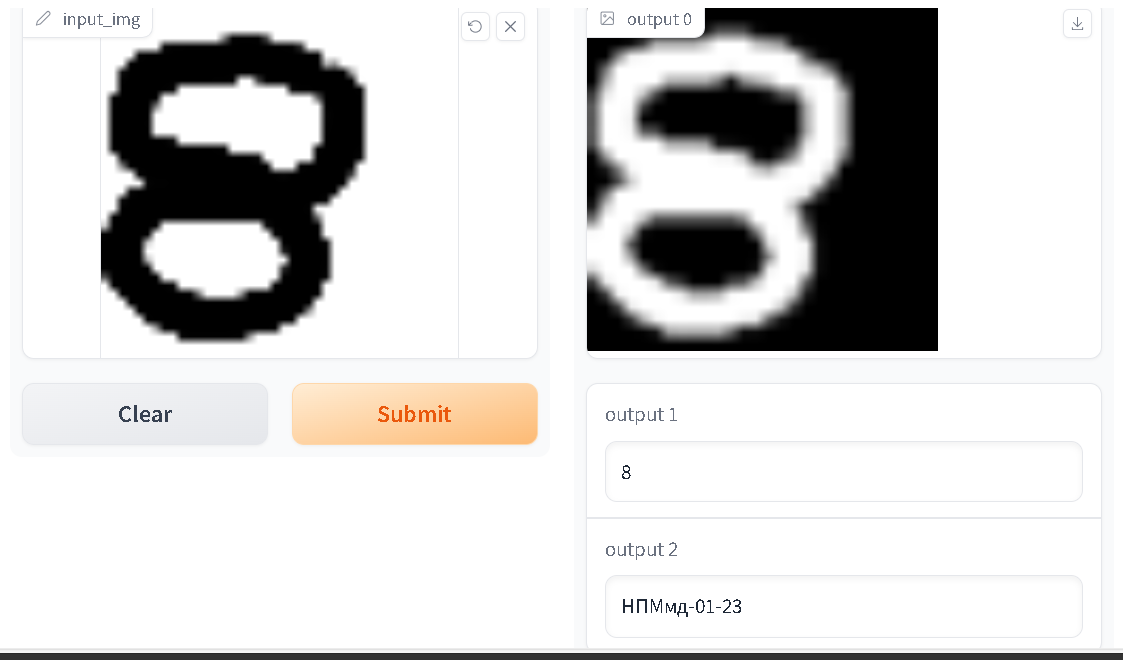

In [164]:
Image.open("8.png")

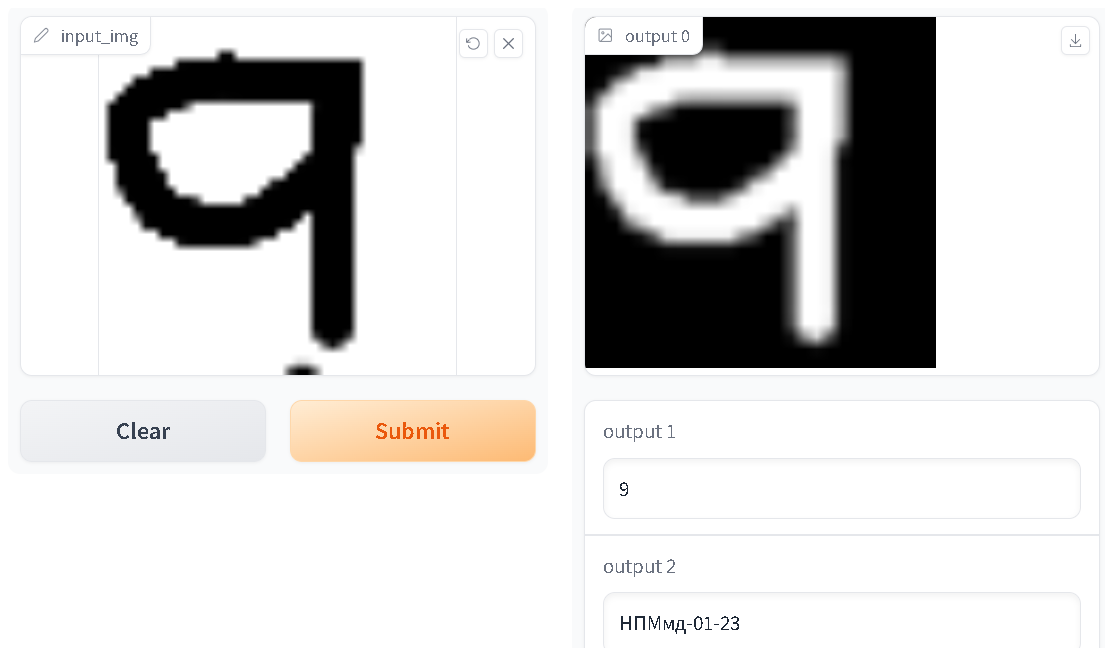

In [165]:
Image.open("9.png")